# Technical Test Torre
By: Jorge Aurelio Valdez Osorio

jorge.valdez.osorio@gmail.com

### Import libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import joblib

import re
from sys import getsizeof

## Initial data exploration and data cleaning

In [2]:
# Add the data in a data frame
data = pd.read_csv('reed_uk.csv')
or_data = data.copy()

First of all we are going to see what data do we have.

In [3]:
data.head()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Norfolk,Swanstaff Recruitment Ltd,uk,reed,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person,"Permanent, full-time",2/27/2018,Salary not specified,East Anglia
3,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England


As a first galnce we can define each field like this:
* category: (str) a category that describes the area of business of the job.
* city: (str) the city where the job is located.
* company_name: (str) company listing the job..
* geo: (str) conuntry where te job is listed
* job_board: (str) ¿?.
* job_description: (str) text descrbing the job listing.
* job_requirements: (str) text thas display the requiremns that an applicant must have to apply for the job.
* job_title: (str) title for the job.
* job_type: (str) This seems to describe two characterístics of the job, the *contract_type* (permanent, temporal, contract, etc) and *daily_work* (full-time or part-time).
* post_date: (date: 'mm/dd/aaaa') publication date of the job listing.
* salary_offered: (str) How much the company is offering to pay for the job.
* state: (str) state where the job is located

Now we see a little description of th data

In [4]:
data.describe()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
count,50000,50000,50000,50000,50000,50000,20548,50000,50000,50000,50000,49980
unique,37,2918,5166,1,1,42057,14887,29155,9,66,7345,167
top,health jobs,London,Hays Specialist Recruitment Limited,uk,reed,Apply on employer's website Add an annual tur...,Required skills Recruitment,Administrator,"Permanent, full-time",3/7/2018,Salary negotiable,London
freq,1930,4349,1830,50000,50000,85,123,162,36864,8472,4539,5900


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          50000 non-null  object
 1   city              50000 non-null  object
 2   company_name      50000 non-null  object
 3   geo               50000 non-null  object
 4   job_board         50000 non-null  object
 5   job_description   50000 non-null  object
 6   job_requirements  20548 non-null  object
 7   job_title         50000 non-null  object
 8   job_type          50000 non-null  object
 9   post_date         50000 non-null  object
 10  salary_offered    50000 non-null  object
 11  state             49980 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


## Data cleaning

### Drop extra columns
With the first table can conclude that the fields *geo* and *job_board* have only one value, thay are note relevant within this data so we drop them.
With the second we see we are having some null values, specially in job requiremnts wher we have more than half the registers as null, also in state we have 20 missing values.

Because we only are missing 20 values and this is nos a significant number of registers we are going to drop de rows with missing state.

Also as city is directly correlated with state, we are going to simlplify the model by just using state.

In [6]:
data = data.drop(columns=['geo', 'job_board', 'city', 'company_name','job_title', 'post_date'])
data = data[np.logical_not(data['state'].isnull())].reset_index(drop=True)
data.head()

,category,job_description,job_requirements,job_type,salary_offered,state
0,catering jobs,Apply now New opportunity not to be missed! H...,NaN,"Permanent, full-time","£18,323 per annum",Devon
1,law jobs,Apply now This role requires an experienced s...,NaN,"Permanent, full-time","£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Apply now Job Title: Warehouse personLocation...,NaN,"Permanent, full-time",Salary not specified,East Anglia
3,law jobs,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,"Permanent, full-time or part-time","£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Apply now International Pharmaceutical Manufa...,NaN,"Permanent, full-time","£37,000 - £45,000 per annum",South East England


In [7]:
data.describe()

,category,job_description,job_requirements,job_type,salary_offered,state
count,49980,49980,20546,49980,49980,49980
unique,37,42038,14885,9,7338,167
top,health jobs,Apply on employer's website Add an annual tur...,Required skills Recruitment,"Permanent, full-time",Salary negotiable,London
freq,1930,85,123,36846,4534,5900


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49980 entries, 0 to 49979
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          49980 non-null  object
 1   job_description   49980 non-null  object
 2   job_requirements  20546 non-null  object
 3   job_type          49980 non-null  object
 4   salary_offered    49980 non-null  object
 5   state             49980 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB


### Cleaninig *category*
We just delete " jobs" from every cactegory to keep it simple.

In [9]:
data['category'] = data['category'].str.replace(' jobs', '', regex=True).replace(' ','_', regex=True)

### Cleaninig *job_description* and *job_requirements*

First we are going to delete common words and characters that does not give information to the model in this context such as "Apply now" then we are going to join this two fields and use TF-IDF to trannsform this data into vectors.

In [10]:
data['job_description'] = data.apply(
    lambda x: f'{x["job_description"]} {x["job_requirements"] if not pd.isnull(x["job_requirements"]) else ""}'.lower(),
    axis=1
)

st_wr = '|'.join([
    # common non importat phrases
    'apply now', 
    'required skills', 
    'looking for', 
    'essential skills', 
    'new opportunity', 
    'not to be missed', 
    'key Attributes:',
    'no agencies',
    'keywords:',
    'position:'
    
    # common text interpretation errros
    'â€™',
    'â€¢',
    'Â\xa0',
    'â€“',
    'â€™',
    'â\xa0',
    'â€¦',
    'â€”',
    'â©',
    'â·',
    'â€œ',
    '\\x9d',
    'â€˜',
    'ã©',
    'ï',
    '·',
    '‚',
    '§',
    'â½',
    'ãƒ',
    'ã´',
    'å',
    '¸',
    'ã',
    '³',
    '\\xa0',
    '‰',
    'ƒ˜',
    'â¾',
    '¬',
    'â',
    '®',
    '\x81',
    '€ª',
    '±',
    '¼',
    '\\xad',
    '„',
    '¶',
    '¤',
    '€',
    'ž',
    '°',
    '»',
    '¿',
    'š',
    '¨',
    'ƒ',
    'º',
    '¥',
    '«',
    '˜',
    '¡',
    '¯',
    'ª',
    
    # delete salaries
    'â*£[0-9,.]+',
    '\$[0-9,.%]+',
    '\$[0-9,.]+',
    '\$',
    'â*£',
    '¢',
    
])

data['job_description'] = data['job_description'].str.replace(st_wr, '', regex=True)
len(data['job_description'][data['job_description'].str.contains(r"[^0-9a-zA-z!\-',/:.* ()\\?@+&;%|\"#=<>~{}]+",regex=True)])

28

We are going to create text to vector models using TF-IDF to vectorize and PCA to reduce dimensionality.
But we are going to create a model per category to enfasize the importance of words in different business.

In [11]:
def txt_cluster_model(category, data):
    corpus = data['job_description'][data['category']==category]
    tfidf_model = TfidfVectorizer(stop_words = 'english', max_features = 50)
    tfidf_model = tfidf_model.fit(corpus)
    tfidf = tfidf_model.transform(data['job_description'][data['category']==category])
    tfidf_norm = normalize(tfidf)
    tfidf_array = tfidf_norm.toarray()
    pca_model = PCA(n_components=10)
    pca_model = pca_model.fit(tfidf_array)
    pca_array = pca_model.transform(tfidf_array)
    kmeans_model = KMeans(n_clusters=10, random_state=0).fit(pca_array)
    
    
    def txt_pca_model_cat(x):
        tfidf_x = tfidf_model.transform(x)
        tfidf_x_norm = normalize(tfidf_x)
        tfidf_x_array = tfidf_x_norm.toarray()
        tfidf_pca_x = pca_model.transform(tfidf_x_array)
        cluster = kmeans_model.predict(tfidf_pca_x)
        return cluster
    
    ## We save this models for implementation
    joblib.dump(tfidf_model, f'models/{category}_tfidf.joblib')
    joblib.dump(pca_model, f'models/{category}_pca.joblib')
    joblib.dump(kmeans_model, f'models/{category}_kmeans.joblib')
    
    
    return txt_pca_model_cat

txt_cluster_models = {cat: txt_cluster_model(cat, data) for cat in data['category'].drop_duplicates()}


In [12]:
temp_ser = pd.Series(dtype=int)
for cat in data['category'].drop_duplicates():
    data_cat = data['job_description'].loc[data['category'] == cat]
    temp_ser = temp_ser.append(
        data['job_description'].loc[data['category'] == cat].map(
            lambda x: txt_cluster_models[cat]([x])[0]
        )
    )

In [13]:
temp_ser = temp_ser.rename('j_d_v')
data = data.join(temp_ser)
data = data.drop(columns=['job_description', 'job_requirements'])
data.head()

,category,job_type,salary_offered,state,j_d_v
0,catering,"Permanent, full-time","£18,323 per annum",Devon,5
1,law,"Permanent, full-time","£18,000 - £22,000 per annum",Wiltshire,9
2,factory,"Permanent, full-time",Salary not specified,East Anglia,7
3,law,"Permanent, full-time or part-time","£15,000 - £17,000 per annum, pro-rata",West Sussex,2
4,factory,"Permanent, full-time","£37,000 - £45,000 per annum",South East England,6


#### Cleaning *job_type*
Now we are going to transform *job_type* to divide it in *contract_type* and *daily_work*

In [14]:
data['contract_type'], data['daily_work'] = np.transpose(data['job_type'].map(lambda x: x.split(',')).to_list())
data = data.drop(columns=['job_type'])
data.head()

,category,salary_offered,state,j_d_v,contract_type,daily_work
0,catering,"£18,323 per annum",Devon,5,Permanent,full-time
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,Permanent,full-time
2,factory,Salary not specified,East Anglia,7,Permanent,full-time
3,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,Permanent,full-time or part-time
4,factory,"£37,000 - £45,000 per annum",South East England,6,Permanent,full-time


Now we change this variables to dummy variables.
First contract_type 

In [15]:
data['contract_type'].drop_duplicates()

0     Permanent
14     Contract
17    Temporary
Name: contract_type, dtype: object

In [16]:
data = pd.concat([data, pd.get_dummies(data['contract_type'], prefix='c_t')], axis=1) 
data = data.drop(columns=['contract_type'])


Now *daily_work*

In [17]:
data['daily_work'].drop_duplicates()

0                  full-time
3     full-time or part-time
5                  part-time
Name: daily_work, dtype: object

In [18]:
data['d_w_fulltime'] = data['daily_work'].map(lambda x: 1 if 'full-time' in x else 0)
data['d_w_parttime'] = data['daily_work'].map(lambda x: 1 if 'part-time' in x else 0)
data = data.drop(columns=['daily_work'])
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0
2,factory,Salary not specified,East Anglia,7,0,1,0,1,0
3,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1
4,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0


### Cleaninig salary

First we eliminate trailing spaces.

In [19]:
data['salary_offered'] = data['salary_offered'].map(lambda x: x.strip())

Now we found all the salaries thar are not specified and change them to Null values

In [20]:
not_spec_re = r'[^0-9]*'
data['salary_offered'][data['salary_offered'].map(lambda x: re.fullmatch(not_spec_re, x) is not None)].drop_duplicates()

2       Salary not specified
12        Competitive salary
41         Salary negotiable
2021         Commission only
Name: salary_offered, dtype: object

We are going to see how many salaries we are missing

In [21]:
len(data['salary_offered'].loc[data['salary_offered'].isin(['Salary not specified', 'Competitive salary', 'Salary negotiable', 'Commission only', '£0 per annum'])])

8898

As there are not so many missing salaries we are goin to drop them.

In [22]:
data['salary_offered'].loc[data['salary_offered'].isin(['Salary not specified', 'Competitive salary', 'Salary negotiable', 'Commission only', '£0 per annum'])] = np.nan
data.head()

/home/jorge/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0
2,factory,NaN,East Anglia,7,0,1,0,1,0
3,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1
4,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0


In [23]:
data = data.dropna(subset=['salary_offered']).reset_index(drop=True)
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0
2,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1
3,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0
4,retail,"£9,100 - £9,152 per annum, OTE",County Antrim,9,0,1,0,0,1


We eliminate "up to" and "from" in the salary offers for the regex cleaning.
And we delete the rows containing "‚¬" as currency character

In [24]:
data['salary_offered'] = data['salary_offered'].replace('up to ', '', regex=True).replace('from ', '', regex=True)

In [25]:
len(data['salary_offered'][data['salary_offered'].str.contains('¬')])

125

In [26]:
data = data[np.logical_not(data['salary_offered'].str.contains('¬'))].reset_index(drop=True)

We define temporary columns where we save the currency and amount of the salaries

In [27]:
min_sal_re = re.compile(r'^(?P<curr1>[^0-9- ]{1,4})(?P<money1>[0-9,.]+)')
data['temp_min_sal'] = data['salary_offered'].map(
    lambda x: min_sal_re.search(x).group('curr1', 'money1') if min_sal_re.search(x) else 'Error'
)

max_sal_re = re.compile(r'- (?P<curr2>[^0-9- ]{1,4})(?P<money2>[0-9,.]+)')
data['temp_max_sal'] = data['salary_offered'].map(
    lambda x: max_sal_re.search(x).group('curr2', 'money2') if max_sal_re.search(x) else np.nan
)
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime,temp_min_sal,temp_max_sal
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0,"(£, 18,323)",NaN
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0,"(£, 18,000)","(£, 22,000)"
2,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1,"(£, 15,000)","(£, 17,000)"
3,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0,"(£, 37,000)","(£, 45,000)"
4,retail,"£9,100 - £9,152 per annum, OTE",County Antrim,9,0,1,0,0,1,"(£, 9,100)","(£, 9,152)"


We confirm we got at least al minimum, the offers that only have one value are saven in the minimum.

In [28]:
data['temp_min_sal'][data['temp_min_sal'] == 'Error']

Series([], Name: temp_min_sal, dtype: object)

Confirmation that there are not empty string in minimum salary

In [29]:
temp = data['temp_min_sal'].map(lambda x: x[1])
(temp[temp==''])

Series([], Name: temp_min_sal, dtype: object)

In [30]:
data['curr_salary'] = data['temp_min_sal'].map(lambda x: x[0])
data['min_salary'] = data['temp_min_sal'].map(lambda x: x[1]).replace(',','', regex=True).astype(float)
data['max_salary'] = data.apply(
    lambda x: x['temp_max_sal'][1] if isinstance(x['temp_max_sal'], tuple) else x['min_salary'],
    axis=1
).replace(',','', regex=True).astype(float)
data = data.drop(columns=['temp_min_sal', 'temp_max_sal'])
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime,curr_salary,min_salary,max_salary
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0,£,18323.0,18323.0
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0,£,18000.0,22000.0
2,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1,£,15000.0,17000.0
3,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0,£,37000.0,45000.0
4,retail,"£9,100 - £9,152 per annum, OTE",County Antrim,9,0,1,0,0,1,£,9100.0,9152.0


Now we define if the salaries are per year, per day or per hour, to standirize per hour.

In [31]:
def salary_period(x):
    if re.search('per annum', x):
        return 'year'
    if re.search('per day', x):
        return 'day'
    if re.search('per hour', x):
        return 'hour'
    return None
data['salary_period'] = data['salary_offered'].map(salary_period)
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime,curr_salary,min_salary,max_salary,salary_period
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0,£,18323.0,18323.0,year
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0,£,18000.0,22000.0,year
2,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1,£,15000.0,17000.0,year
3,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0,£,37000.0,45000.0,year
4,retail,"£9,100 - £9,152 per annum, OTE",County Antrim,9,0,1,0,0,1,£,9100.0,9152.0,year


Confirm not null values in *salary_period*

In [32]:
len(data['salary_period'][pd.isnull(data['salary_period'])])

0

Finally we are going to define our maximum and minimum salary in pounds per hour.

In [33]:
# currencies exchange_rates
cur_er = {
    '£': 1,
    'USD$':1.38,
    'AUD$':1.79
}
# time periods
time_pr = {
    'hour': 1,
    'day':1/8,
    'year': 1/(255*8) # 255 working days in the year * hours per working day
}
# based in https://hello-safe.co.uk/business-insurance/tools/working-days-calculator
    

In [34]:
data['max_salary'] = data.apply(
    lambda x: x['max_salary']*cur_er[x['curr_salary']]*time_pr[x['salary_period']],
    axis=1
)
data['min_salary'] = data.apply(
    lambda x: x['min_salary']*cur_er[x['curr_salary']]*time_pr[x['salary_period']],
    axis=1
)
data.head()

,category,salary_offered,state,j_d_v,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime,curr_salary,min_salary,max_salary,salary_period
0,catering,"£18,323 per annum",Devon,5,0,1,0,1,0,£,8.981863,8.981863,year
1,law,"£18,000 - £22,000 per annum",Wiltshire,9,0,1,0,1,0,£,8.823529,10.784314,year
2,law,"£15,000 - £17,000 per annum, pro-rata",West Sussex,2,0,1,0,1,1,£,7.352941,8.333333,year
3,factory,"£37,000 - £45,000 per annum",South East England,6,0,1,0,1,0,£,18.137255,22.058824,year
4,retail,"£9,100 - £9,152 per annum, OTE",County Antrim,9,0,1,0,0,1,£,4.460784,4.486275,year


We use a boxplot diagram to find outliers.


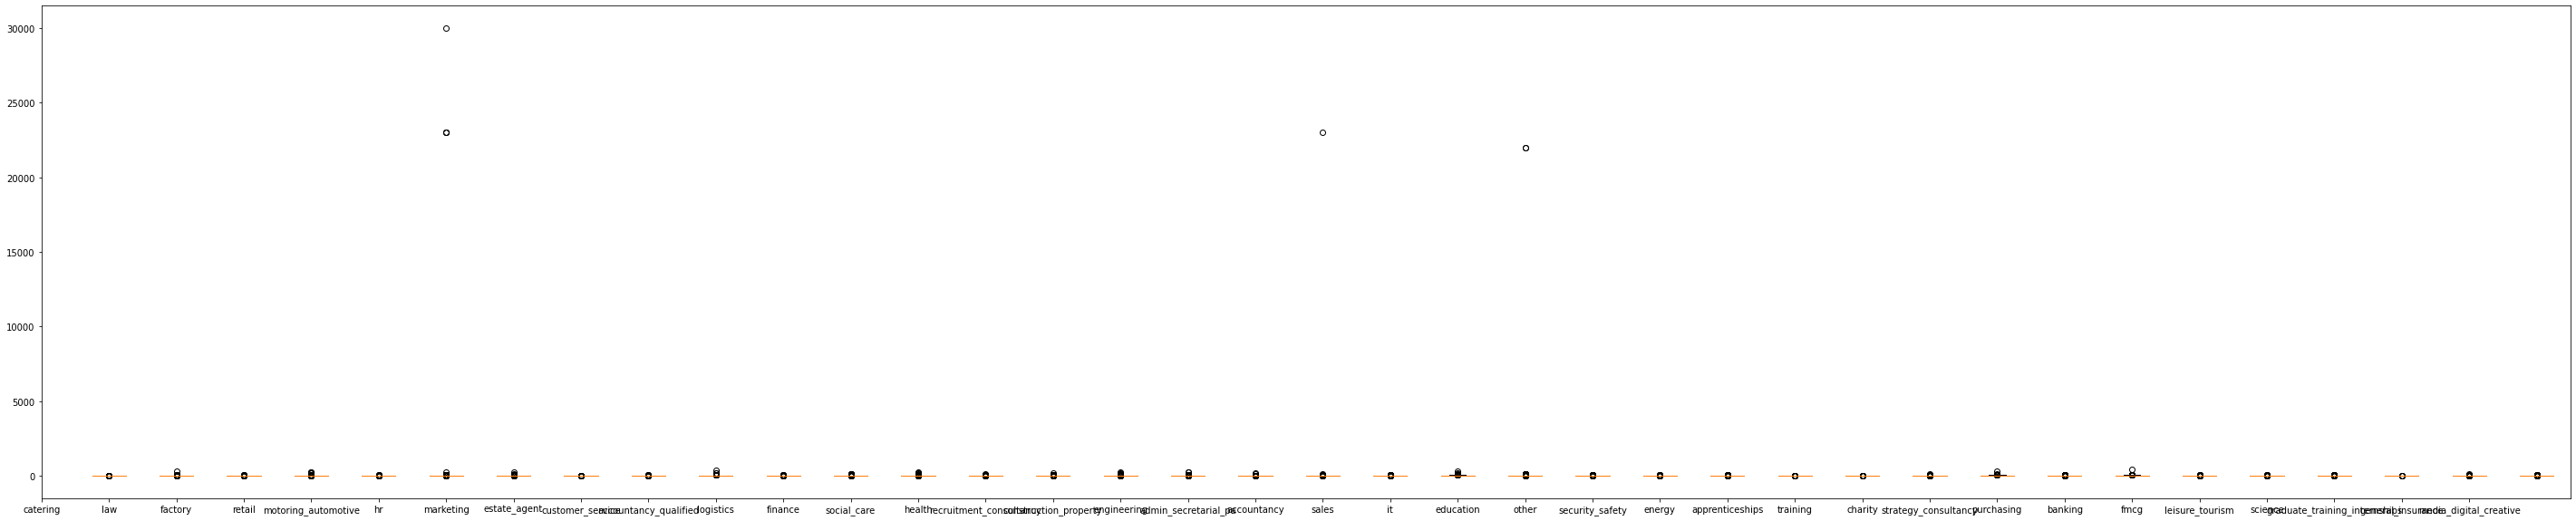

In [35]:
min_salaries_by_cat = [data['min_salary'][data['category']==x] for x in data['category'].drop_duplicates()]
bp_sal, ax_bp_sal = plt.subplots(figsize=(50,10))

bp = ax_bp_sal.boxplot(min_salaries_by_cat)
ticks =plt.xticks([x for x in range(len(data['category'].drop_duplicates()))], data['category'].drop_duplicates())

Fist we drop everything over 500 per hour.

In [36]:
data = data[data['min_salary']<500].reset_index(drop=True)

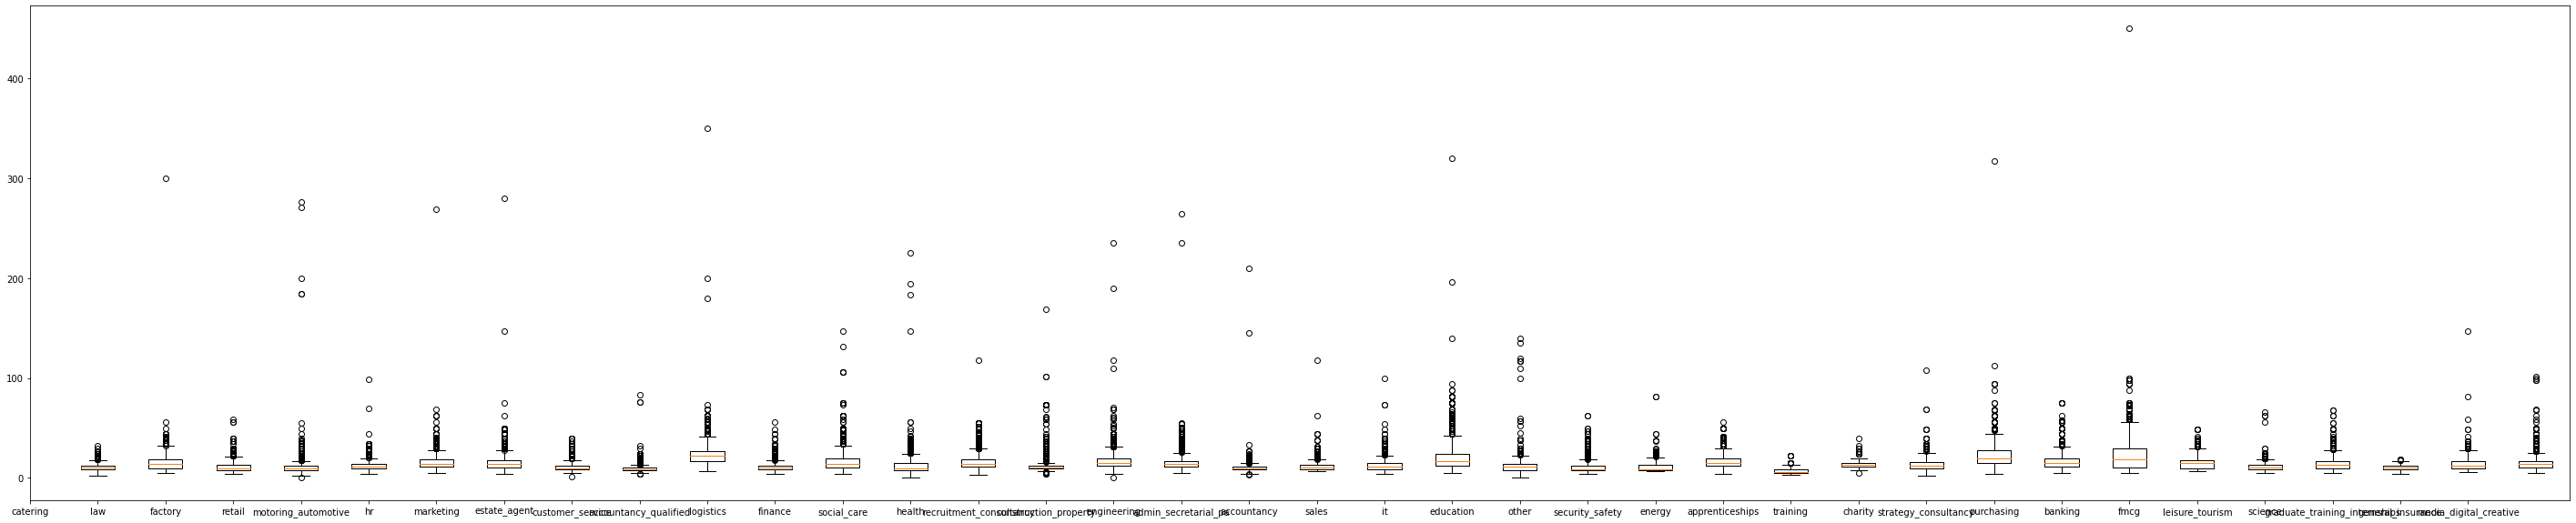

In [37]:
min_salaries_by_cat = [data['min_salary'][data['category']==x] for x in data['category'].drop_duplicates()]
bp_sal, ax_bp_sal = plt.subplots(figsize=(50,10))

bp = ax_bp_sal.boxplot(min_salaries_by_cat)
ticks =plt.xticks([x for x in range(len(data['category'].drop_duplicates()))], data['category'].drop_duplicates())

In [38]:
data = data[data['min_salary']<100].reset_index(drop=True)

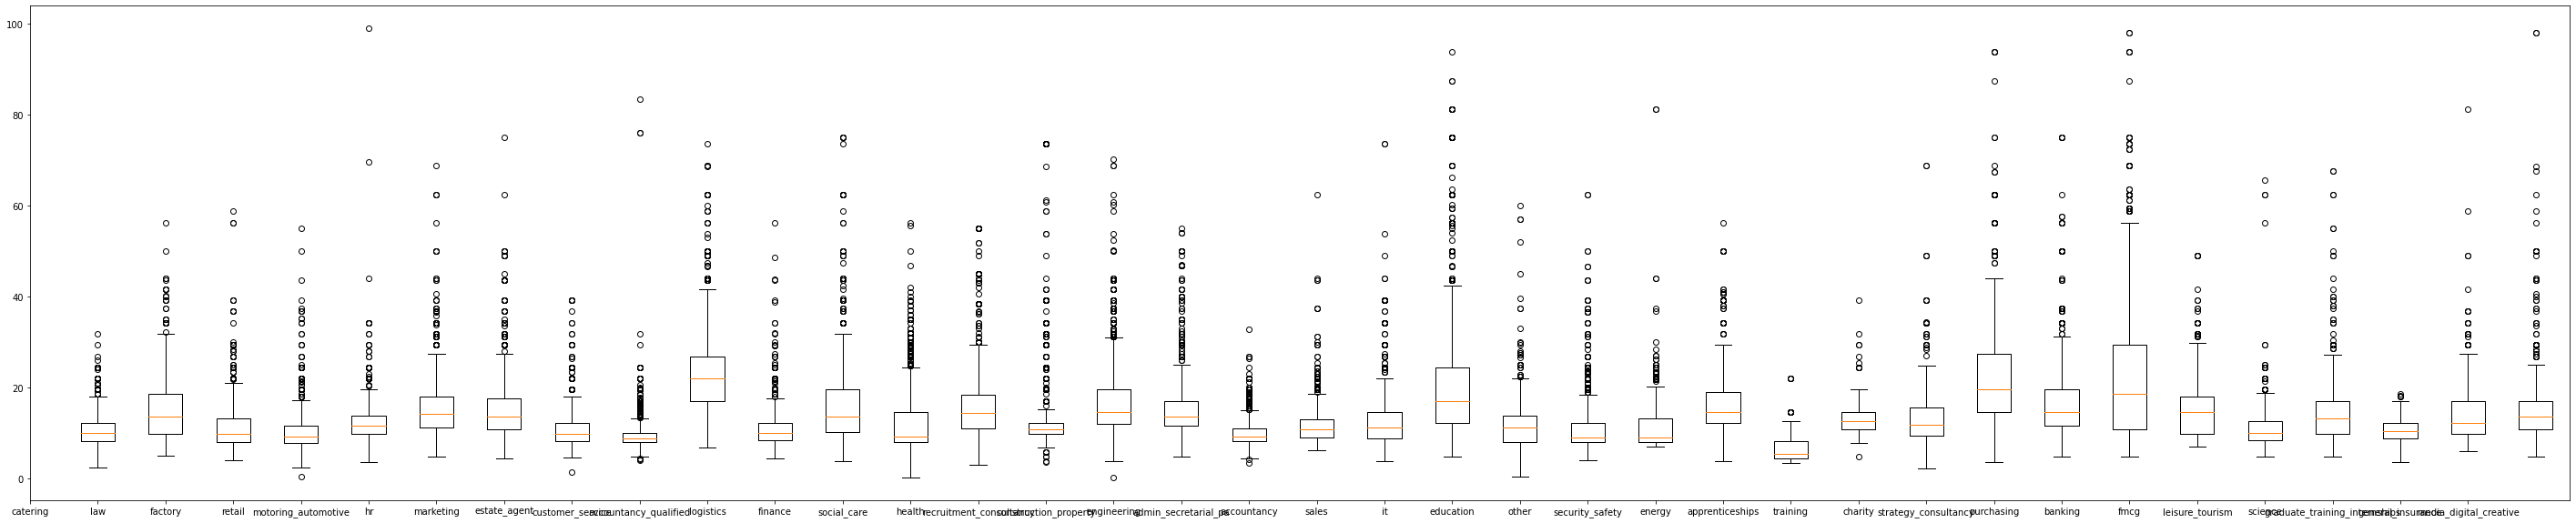

In [39]:
min_salaries_by_cat = [data['min_salary'][data['category']==x] for x in data['category'].drop_duplicates()]
bp_sal, ax_bp_sal = plt.subplots(figsize=(50,10))

bp = ax_bp_sal.boxplot(min_salaries_by_cat)
ticks =plt.xticks([x for x in range(len(data['category'].drop_duplicates()))], data['category'].drop_duplicates())

No we see if the max salaries have outliers

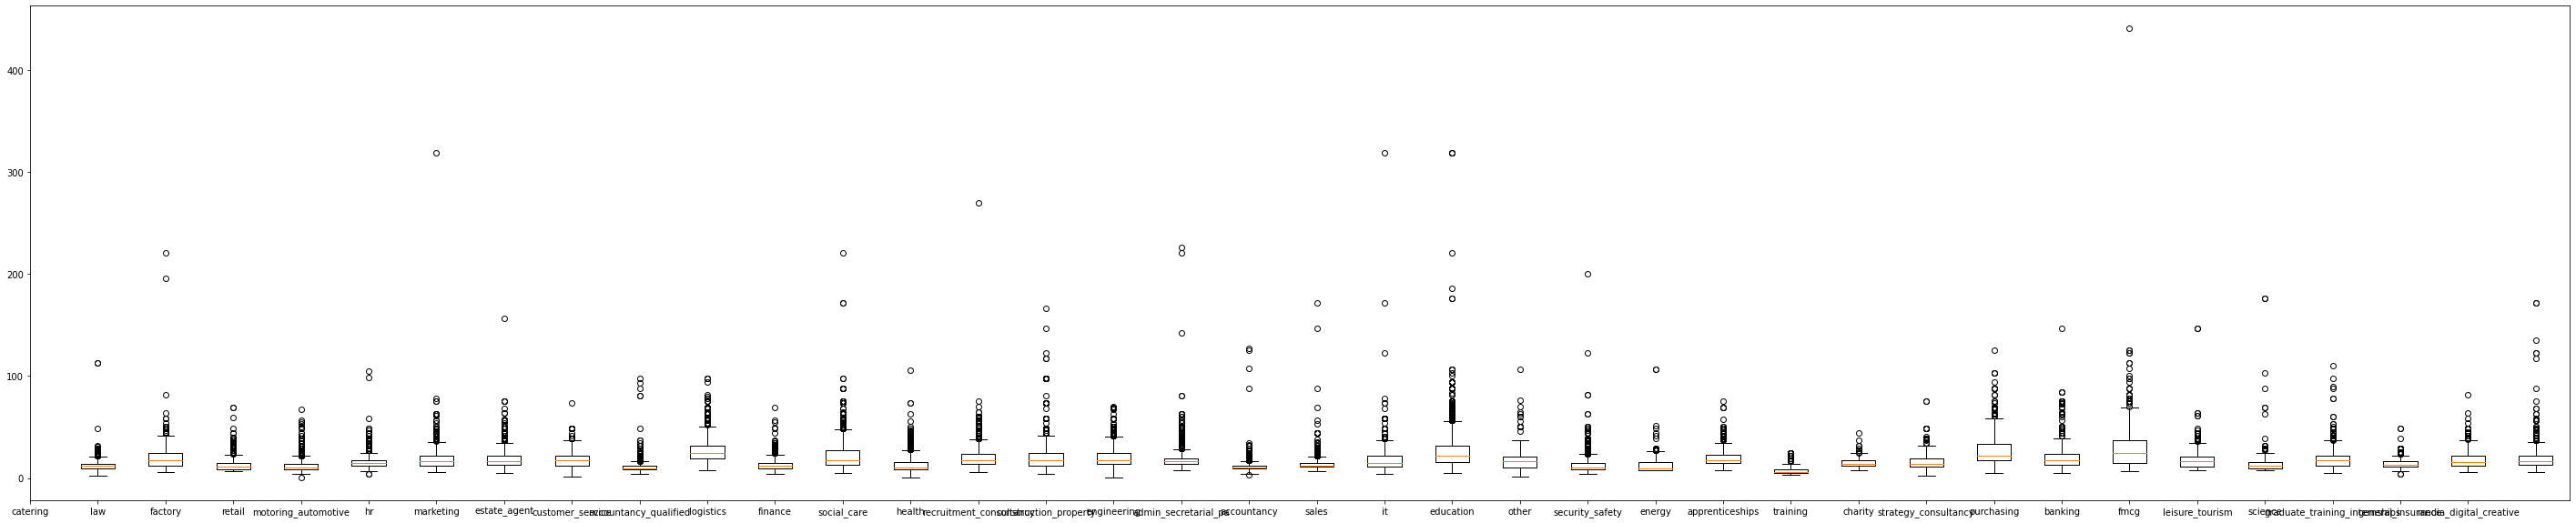

In [40]:
max_salaries_by_cat = [data['max_salary'][data['category']==x] for x in data['category'].drop_duplicates()]
bp_sal, ax_bp_sal = plt.subplots(figsize=(50,10))

bp = ax_bp_sal.boxplot(max_salaries_by_cat)
ticks =plt.xticks([x for x in range(len(data['category'].drop_duplicates()))], data['category'].drop_duplicates())

We can see we have some values that may be outliers, let's see some of them to understand what is happening.

In [41]:
len(data[data['max_salary'] >= 150])

27

We conclude that they are errors made in the input of the data, we proceed to drop them.

In [42]:
data = data[data['max_salary']<150].reset_index(drop=True)

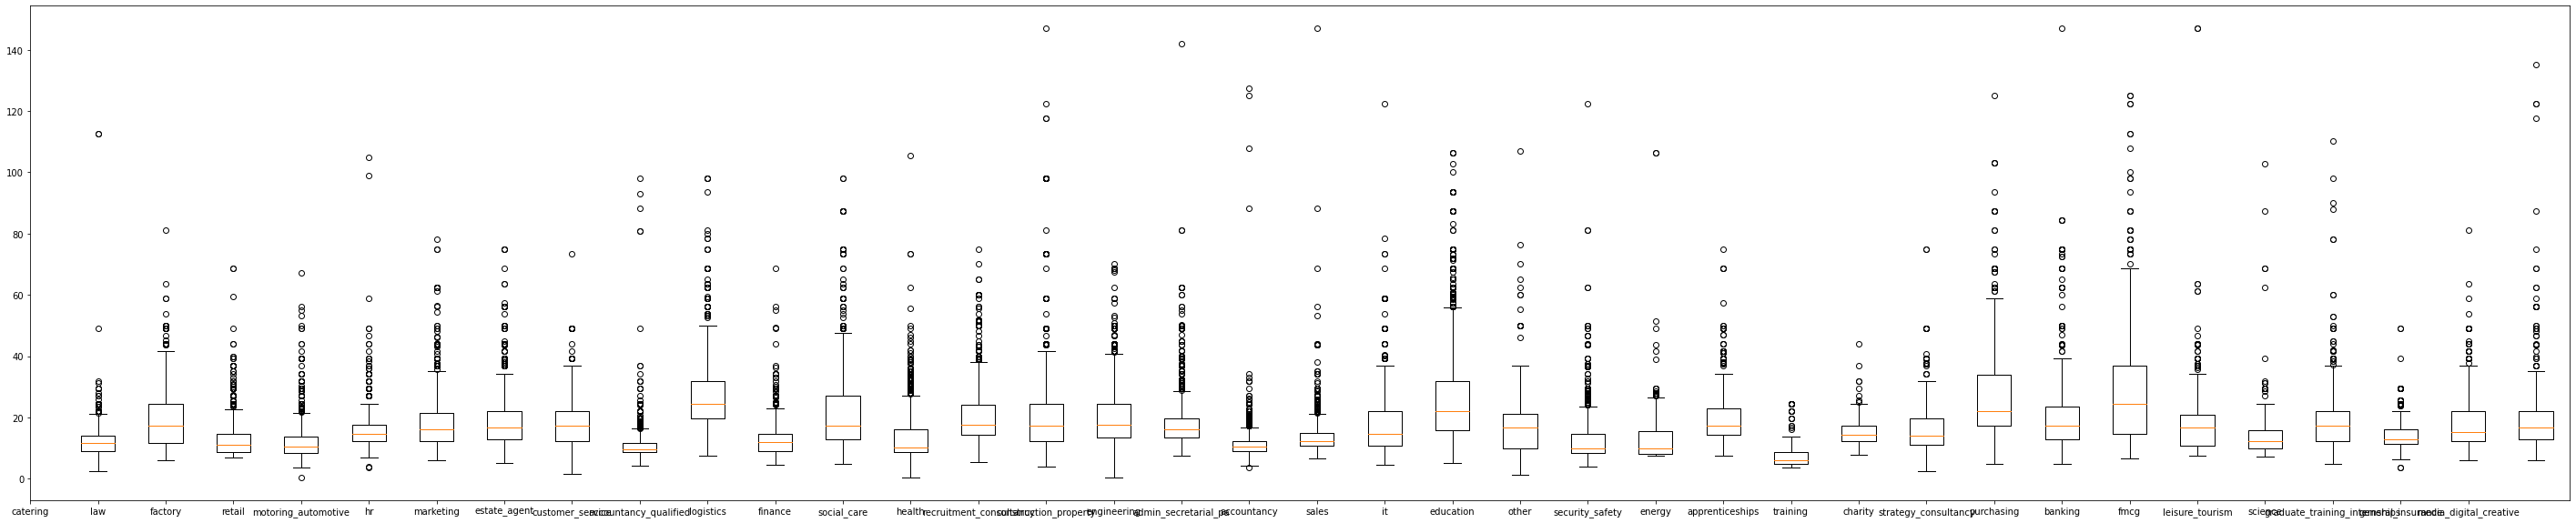

In [43]:
max_salaries_by_cat = [data['max_salary'][data['category']==x] for x in data['category'].drop_duplicates()]
bp_sal, ax_bp_sal = plt.subplots(figsize=(50,10))
# ax_bp_sal.xlabel(data['category'].drop_duplicates())

bp = ax_bp_sal.boxplot(max_salaries_by_cat)
ticks =plt.xticks([x for x in range(len(data['category'].drop_duplicates()))], data['category'].drop_duplicates())

We dropped columns that we are not going to use anymore.

In [44]:
data = data.drop(columns=['curr_salary','salary_period','salary_offered'])

### Clean *state*, *category*, *j_d_v*

Dummify variables for later use

In [45]:
data = pd.concat([data, pd.get_dummies(data['state'], prefix='state')], axis=1)
data = pd.concat([data, pd.get_dummies(data['category'], prefix='category')], axis=1)
data = pd.concat([data, pd.get_dummies(data['j_d_v'], prefix='j_d_v')], axis=1)
data = data.drop(columns=['state', 'category', 'j_d_v'])
data.head()

,c_t_Contract,c_t_Permanent,c_t_Temporary,d_w_fulltime,d_w_parttime,min_salary,max_salary,state_Aberdeen,state_Aberdeenshire,state_Abu Dhabi,...,j_d_v_0,j_d_v_1,j_d_v_2,j_d_v_3,j_d_v_4,j_d_v_5,j_d_v_6,j_d_v_7,j_d_v_8,j_d_v_9
0,0,1,0,1,0,8.981863,8.981863,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,1,0,8.823529,10.784314,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,1,1,7.352941,8.333333,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,1,0,18.137255,22.058824,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,1,4.460784,4.486275,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Model proposal

We are going to build a model that predicts the salary.
The objective is for a company to post a job and get an estimation of how much they should pay to this position.

For this we are going to first analyze the salary variable

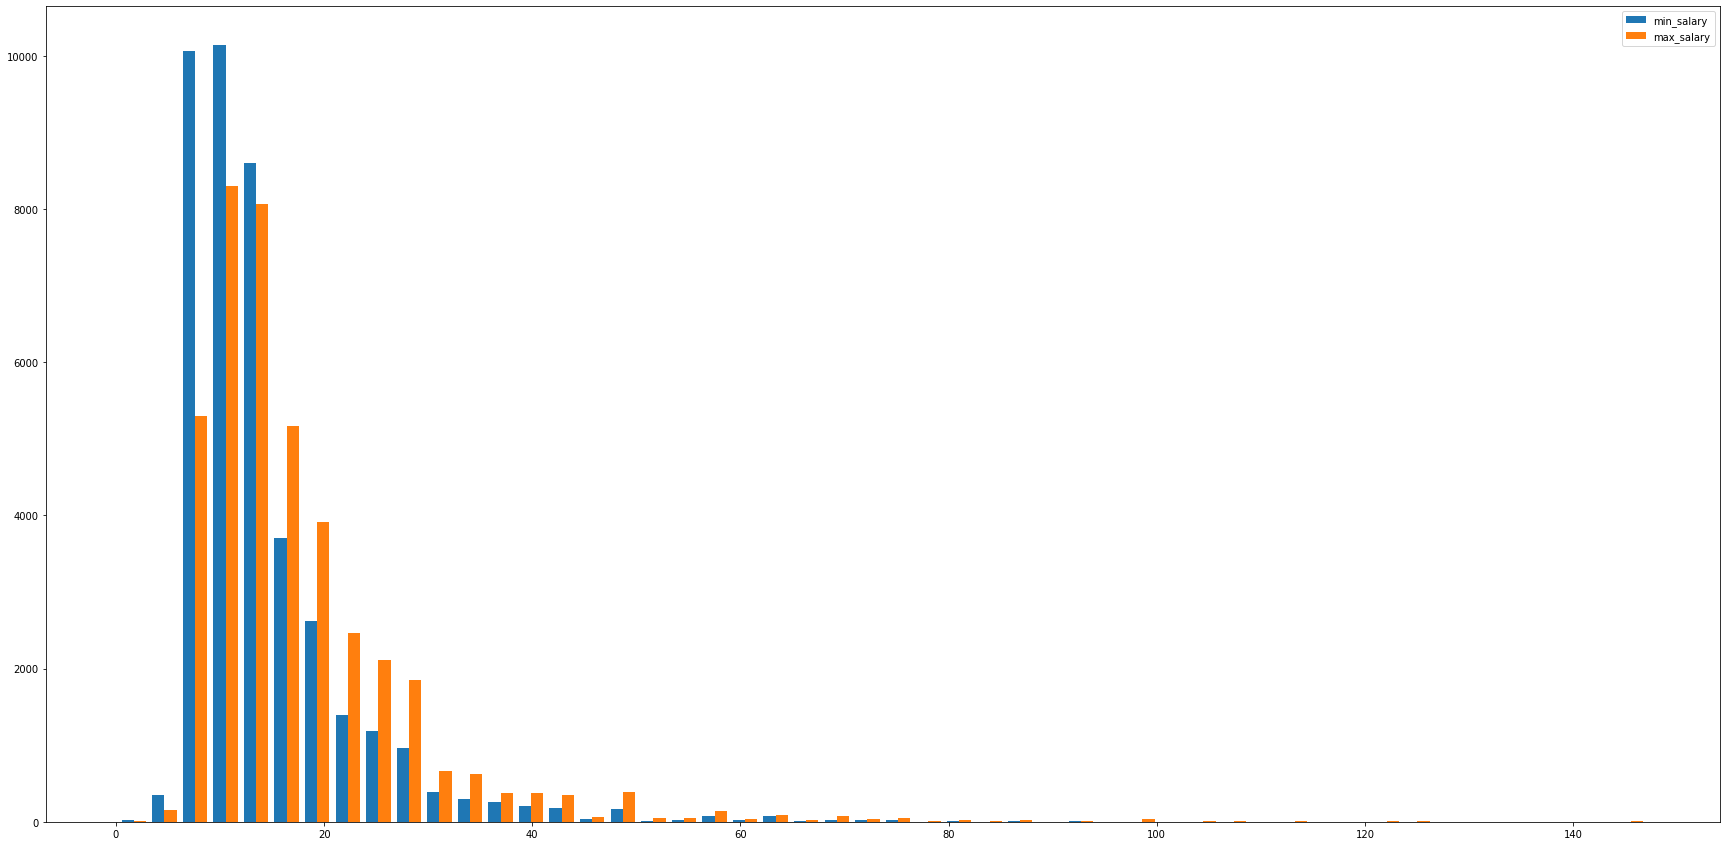

In [46]:
hist_fig, hist_ax = plt.subplots(figsize=(30,15))
hist_ax.hist(data[['min_salary', 'max_salary']], bins = 50, label=['min_salary', 'max_salary'])
hist_ax.legend()
plt.show()

In [47]:
data[['min_salary', 'max_salary']].describe()

,min_salary,max_salary
count,40868.000000,40868.000000
mean,14.250084,17.555207
std,8.278989,10.891853
min,0.257353,0.305882
25%,9.000000,10.784314
50%,12.000000,14.705882
75%,16.600000,20.588235
max,99.000000,147.058824


In [48]:
y1 = data['min_salary']
y2 = data['max_salary']

x = data.drop(columns = ['min_salary', 'max_salary'])

### Minimum salary regressors

Divide the data set in train and test datasets.

In [49]:
min_x_train, min_x_test, min_y_train, min_y_test = train_test_split(
    x, y1, test_size=0.1)

#### Support verctos machines regressors
Polynomial kernel

In [50]:
min_svr_regressor = SVR(kernel='poly')
min_svr_regressor.fit(min_x_train, min_y_train)
min_svr_regressor.score(min_x_test, min_y_test)

0.3449998625572803

Radial basis function kernel

In [51]:
min_svr_regressor = SVR(kernel='rbf')
min_svr_regressor.fit(min_x_train, min_y_train)
min_svr_regressor.score(min_x_test, min_y_test)

0.32069275617728443

Linear kernel

In [52]:
min_svr_regressor = SVR(kernel='linear')
min_svr_regressor.fit(min_x_train, min_y_train)
min_svr_regressor.score(min_x_test, min_y_test)

0.20101752640558546

#### Random forest regressor

In [ ]:
min_rf_regressor = RandomForestRegressor(n_estimators=1000)
min_rf_regressor.fit(min_x_train, min_y_train)
min_rf_regressor.score(min_x_test, min_y_test)

#### Simple fully connected neural network
4 fully connected leayers with LeakyReLu activation function

In [ ]:
dim_in = len(x.columns)
dim_out = 1
dim_hidden = [400, 200, 100]
epochs = 100
batch_size=10
loss_fn = torch.nn.MSELoss() # loss function
lr = 1e-3 # learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device='cpu'

In [ ]:
device

In [ ]:
min_nn_model = torch.nn.Sequential(
    torch.nn.Linear(dim_in, dim_hidden[0]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[0], dim_hidden[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[1], dim_hidden[2]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[2], dim_out),
)
min_nn_model.to(device)

In [ ]:
x_torch = torch.tensor(min_x_train.values, dtype=torch.float, device=device)
y_torch = torch.tensor(min_y_train.values, dtype=torch.float, device=device)


min_torch_data = torch.utils.data.TensorDataset(x_torch, y_torch)

loader = torch.utils.data.DataLoader(
    dataset=min_torch_data,
    batch_size=batch_size,
    shuffle=True
)
x_torch.shape

In [ ]:
for epoch in range(epochs):
    y_hat = min_nn_model(x_torch)
    loss = loss_fn(y_hat, y_torch)
    
    if epoch%10 == 9:
        print(epoch, loss.item())
    
    min_nn_model.zero_grad()
    
    loss.backward()
    
    with torch.no_grad():
        for param in min_nn_model.parameters():
            param -= lr * param.grad

In [ ]:
r2_score(min_nn_model(torch.tensor(min_x_test.values, dtype=torch.float)).detach().numpy(), min_y_test.values)

### Maximum salary regressors

Divide the data set in train and test datasets.

In [ ]:
max_x_train, max_x_test, max_y_train, max_y_test = train_test_split(
    x, y2, test_size=0.1)

#### Support verctos machines regressors
Polynomial kernel

In [ ]:
max_svr_regressor = SVR(kernel='poly')
max_svr_regressor.fit(max_x_train, max_y_train)
max_svr_regressor.score(max_x_test, max_y_test)

Radial basis function kernel

In [ ]:
max_svr_regressor = SVR(kernel='rbf')
max_svr_regressor.fit(max_x_train, max_y_train)
max_svr_regressor.score(max_x_test, max_y_test)

Linear kernel

In [ ]:
max_svr_regressor = SVR(kernel='linear')
max_svr_regressor.fit(max_x_train, max_y_train)
max_svr_regressor.score(max_x_test, max_y_test)

#### Random forest regressor

In [ ]:
max_rf_regressor = RandomForestRegressor(n_estimators=1000)
max_rf_regressor.fit(max_x_train, max_y_train)
max_rf_regressor.score(max_x_test, max_y_test)

#### Simple fully connected neural network
4 fully connected leayers with LeakyReLu activation function

In [ ]:
dim_in = len(x.columns)
dim_out = 1
dim_hidden = [400, 200, 100]
epochs = 100
batch_size=10
loss_fn = torch.nn.MSELoss() # loss function
lr = 1e-3 # learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device='cpu'

In [ ]:
device

In [ ]:
max_nn_model = torch.nn.Sequential(
    torch.nn.Linear(dim_in, dim_hidden[0]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[0], dim_hidden[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[1], dim_hidden[2]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_hidden[2], dim_out),
)
max_nn_model.to(device)

In [ ]:
x_torch = torch.tensor(max_x_train.values, dtype=torch.float, device=device)
y_torch = torch.tensor(max_y_train.values, dtype=torch.float, device=device)


max_torch_data = torch.utils.data.TensorDataset(x_torch, y_torch)

loader = torch.utils.data.DataLoader(
    dataset=max_torch_data,
    batch_size=batch_size,
    shuffle=True
)
x_torch.shape

In [ ]:
for epoch in range(epochs):
    y_hat = max_nn_model(x_torch)
    loss = loss_fn(y_hat, y_torch)
    
    if epoch%10 == 9:
        print(epoch, loss.item())
    
    max_nn_model.zero_grad()
    
    loss.backward()
    
    with torch.no_grad():
        for param in max_nn_model.parameters():
            param -= lr * param.grad

In [ ]:
r2_score(max_nn_model(torch.tensor(max_x_test.values, dtype=torch.float)).detach().numpy(), max_y_test.values)

We dump the models for production enviroment

In [ ]:
joblib.dump(max_rf_regressor, 'models/max_salary_rf')

In [ ]:
joblib.dump(min_rf_regressor, 'models/min_salary_rf')

In [ ]:
data.to_csv('data.csv')

## Conclusions

## Next steps